# Predicting Health Inspection Violaitons from Yelp Reviews and Business Attributes

## 1. Environment Setup

In [5]:
import psycopg2 as psy
import pandas as pd
import re
import numpy as np
import ast
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
import scipy.sparse
import sklearn.pipeline as pipe

## 2. Data Preparation

Connect to database and download initial datasets. These datasets are materialized views of the Yelp business data converted from JSON format, and the Toronto Inspection dataset imported from CSV. All attributes have been normalized to remove leading spaces, JSON tags, and unreadable characters.

In [6]:
#set up connection to our DB
conn = psy.connect(database="sterndsyelp", 
                        user="mvsternds", 
                        password="nyustern123!", 
                        host="sterndsyelp.cawzspvmqd5q.us-east-1.rds.amazonaws.com", 
                        port="5432"
                       )
#open cursor and check our tables in the DB
cur = conn.cursor()

In [7]:
#get Yelp review text
cur.execute("SELECT * FROM public.toronto_reviews")
reviews = pd.DataFrame(cur.fetchall())
reviews.columns = ['bizID','reviewID','userID','type','stars','text','useful','funny','cool','date']

#get total reviews per biz
rev = reviews['bizID'].value_counts()
rev_counts = pd.DataFrame(rev).reset_index()
rev_counts.columns = ['bizID','all_review_count']

### Join Yelp Review Data with Inspection Dataset

#### Levenshtein Distance (in-database) 
This option joins the yelp restaurant informaiton to each inspection record where:
 * The [Levenshtein distance](https://xlinux.nist.gov/dads/HTML/Levenshtein.html) of the restaurant name from the two datasets is <3
 * The distance of the address from each dataset is <4
 * The date of the review is greater than the prior inspection date
 * The date of the review is less than or equal to inspeciton date on the record
 * The absolute value difference of the "star" rating in the review is less than or equal to 2 (this may reduce biased reviews that are too far from the mean)
 
Whitespace at the beginning and end of the name and address in each dataset is trimmed, and the strings are converted to uppercase before matching. The mathcing thresholds can be adjusted to increase potential for matching, or decrease false matches.

In [8]:
# The materialized view of the restaurant, inspection, and review data is "toronto_all"
cur.execute("SELECT * FROM public.toronto_all_3 where review_date is not null and attributes is not null" )
obs = pd.DataFrame(cur.fetchall())
obs.head()
obs.columns=['bizID','name','address','postal_code','neighborhood','lat','long','categories','attributes','is_open','review_cnt','hours','stars','setablishment_id','establishment_name','establishment_address','inspection_date','last_inspection','count_minor','count_sig','count_crucial','count_na','count_crucial_signficant','review_id','user_id','review_stars','review_text','useful','funny','cool','review_dt']
obs.head()

,bizID,name,address,postal_code,neighborhood,lat,long,categories,attributes,is_open,...,count_na,count_crucial_signficant,review_id,user_id,review_stars,review_text,useful,funny,cool,review_dt
0,0Yh6U06nGLjAMwCw6l9-DA,YANGSBBQRESTAURANT,4186FINCHAVENUEE,M1S 5C9,Scarborough,43.8042008789,-79.2884373665,"['Restaurants', 'Barbeque']","['Alcohol: beer_and_wine', ""Ambience: {'romant...",1,...,0,2,dy4lv5ur08x_fCKMf2yJGA,YvzoOqfBProz9SveFwJYOw,3,Late night Northern Chinese BBQ restaurant in ...,0,0,0,2015-10-20
1,0Yh6U06nGLjAMwCw6l9-DA,YANGSBBQRESTAURANT,4186FINCHAVENUEE,M1S 5C9,Scarborough,43.8042008789,-79.2884373665,"['Restaurants', 'Barbeque']","['Alcohol: beer_and_wine', ""Ambience: {'romant...",1,...,0,1,rby1MutMX_kanEFJ30P3hg,blCeqedLmBNssP7oft_hAg,4,"""We stumbled on this restaurant and weren't su...",0,0,0,2016-10-01
2,0Yh6U06nGLjAMwCw6l9-DA,YANGSBBQRESTAURANT,4186FINCHAVENUEE,M1S 5C9,Scarborough,43.8042008789,-79.2884373665,"['Restaurants', 'Barbeque']","['Alcohol: beer_and_wine', ""Ambience: {'romant...",1,...,0,4,OIt9UjEW9KBZ6XL5B5kkGw,wGQJjtcG1-NsxslGv4bNjw,2,"""My first impression of this place was that it...",0,0,0,2016-05-15
3,0Yh6U06nGLjAMwCw6l9-DA,YANGSBBQRESTAURANT,4186FINCHAVENUEE,M1S 5C9,Scarborough,43.8042008789,-79.2884373665,"['Restaurants', 'Barbeque']","['Alcohol: beer_and_wine', ""Ambience: {'romant...",1,...,0,0,TMHqEjNQbtkbsmmxqfXGAg,7ymTU1NY3NXM0PnT_Z0Qhg,4,"""Went here with some friends and had the Sichu...",0,0,0,2016-01-29
4,0Yh6U06nGLjAMwCw6l9-DA,YANGSBBQRESTAURANT,4186FINCHAVENUEE,M1S 5C9,Scarborough,43.8042008789,-79.2884373665,"['Restaurants', 'Barbeque']","['Alcohol: beer_and_wine', ""Ambience: {'romant...",1,...,0,0,sodiJQbduh11MUG7xPR0Iw,Hk7n0zKhcrRwkvqgb_MQ3Q,4,"""Came here for lunch on a Sunday around 1.30pm...",0,0,0,2016-01-11


In [9]:
#create a primary key of restaurant ID and each unique inspection date for that restaurant
obs['bizID-dt'] = obs['bizID'] + "-" + obs['inspection_date'].map(str)

In [10]:
#get counts of in scope reviews for each inspeciton date of a given restaurant
in_scope_rev = obs['bizID-dt'].value_counts()
in_scope_reviews = pd.DataFrame(in_scope_rev).reset_index()
in_scope_reviews.columns = ['bizID-dt','count_reviews_in_scope']
in_scope_reviews.head()

,bizID-dt,count_reviews_in_scope
0,RwRNR4z3kY-4OsFqigY5sw-2015-11-03,233
1,jc3p5SFyt9qrrMXt6E13ig-2016-12-21,156
2,RwRNR4z3kY-4OsFqigY5sw-2016-03-15,148
3,h_4dPV9M9aYaBliH1Eoeeg-2016-05-12,138
4,trKyIRyjKqVSZmcU0AnICQ-2016-04-11,112


In [11]:
#get dummies for star rating column
obs = pd.concat([obs, pd.get_dummies(obs['review_stars'], prefix='stars')], axis=1)

In [12]:
#Get counts of each star rating for a given restaurant
stars = obs.groupby('bizID-dt')[['stars_1', 'stars_2','stars_3','stars_4','stars_5']].sum().reset_index()
stars.head()

,bizID-dt,stars_1,stars_2,stars_3,stars_4,stars_5
0,-2TBP3ZGu7M-FmfoNJvbrQ-2016-09-07,0,1,0,2,0
1,-2TBP3ZGu7M-FmfoNJvbrQ-2017-01-18,0,0,1,3,1
2,-76didnxGiiMO80BjSpYsQ-2015-09-01,1,1,0,0,0
3,-76didnxGiiMO80BjSpYsQ-2016-03-01,1,4,0,1,0
4,-76didnxGiiMO80BjSpYsQ-2016-09-29,2,3,0,1,1


In [13]:
#merge review text based on the business-inspection date primary key
combined_revs = obs.groupby('bizID-dt')['review_text'].apply(' '.join).reset_index()

In [14]:
#get a unique count of the users that reviewed the restaurant after the last inspection 
#and before the current inspection
users = obs.groupby('bizID-dt')['user_id'].count().reset_index()
users.columns = ['bizID-dt','count_unique_users']

In [15]:
sub = obs[['bizID-dt','bizID',
           'name','postal_code',
           'lat','long','categories',
           'attributes','is_open',
           'count_crucial_signficant','stars']]
sub = sub.drop_duplicates()

In [16]:
#merge in all data into one df
df1 = pd.merge(sub,stars,on='bizID-dt', how='left')
df2 = pd.merge(df1,combined_revs,on='bizID-dt', how='left')
df3 = pd.merge(df2,rev_counts,on='bizID', how='left')
df4 = pd.merge(df3,in_scope_reviews,on='bizID-dt', how='left')
df5 = pd.merge(df4,users,on='bizID-dt', how='left')


### Parsing the "Categories" and "Attributes" columns into unique features
The next cell parses the 'Categories' and 'Attributes' columns,which are nested dicitonaries of different attributesof each restaurant. The categroy column captures descriptive features such as the types of cuisine served, and wheter or not the restaurant is a bar. The atttributes column captures features such as the 'ambiance' of the restaurant, parking, noise level, and other unique features.

In [17]:
t = []
for i in range(len(df5['categories'])):
    x = ast.literal_eval(df5['categories'][i])
    t.append(x)
    
cats = pd.DataFrame(t)
cats_df = pd.get_dummies(cats, prefix='Category')
cats_df = cats_df.groupby(cats_df.columns, axis=1).sum()


atts_df = pd.DataFrame()
for x in range(len(df5['attributes'])):
    list_yelp = ast.literal_eval(df5['attributes'][x])

    attribute_list = []
    attribute_name = []

    for i in list_yelp:

        name = i.split(":")[0]
        values = i.split( name+": " )[1].replace('{','').replace('}','')

        if len(values.split(":")) > 1: 
        
            for j in values.split(","):
                name_j = name + "_" + (j.split(":")[0].strip().replace("'",''))
                attribute_name.append( name_j )
                attribute_list.append (j.split(":")[1])
        else:
            attribute_name.append( name )
            attribute_list.append ( values )
        
    dataframe = pd.DataFrame(attribute_list).transpose()
    dataframe.columns = attribute_name
    atts_df = atts_df.append(dataframe)
    
atts_df = atts_df.reset_index().drop('index', 1)

df = pd.concat([df5, cats_df, atts_df], axis=1)


Next, we create dummy variables for all of the attribute and category features that were generated in the previous step. We want to capture if the attribute is true, false, or nor applicable for the restaurant.

In [18]:
#dummy-ize all categorical and boolean variables
df=pd.get_dummies(df, columns=[
 'Alcohol',
 'Ambience_casual',
 'Ambience_classy',
 'Ambience_hipster',
 'Ambience_intimate',
 'Ambience_romantic',
 'Ambience_touristy',
 'Ambience_trendy',
 'Ambience_upscale',
 'BikeParking',
 'BusinessAcceptsCreditCards',
 'BusinessParking_garage',
 'BusinessParking_lot',
 'BusinessParking_street',
 'BusinessParking_valet',
 'BusinessParking_validated',
 'Caters',
 'GoodForKids',
 'GoodForMeal_breakfast',
 'GoodForMeal_brunch',
 'GoodForMeal_dessert',
 'GoodForMeal_dinner',
 'GoodForMeal_latenight',
 'GoodForMeal_lunch',
 'HasTV',
 'NoiseLevel',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'WiFi', 
 'is_open',
'BestNights_friday',
 'BestNights_monday',
 'BestNights_saturday',
 'BestNights_sunday',
 'BestNights_thursday',
 'BestNights_tuesday',
 'BestNights_wednesday',
     'ByAppointmentOnly',
 'CoatCheck',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'HappyHour',
 'Music_background_music',
 'Music_dj',
 'Music_jukebox',
 'Music_karaoke',
 'Music_live',
 'Music_no_music',
 'Music_video',
 'Open24Hours',
 'RestaurantsCounterService',
 'Smoking',
 'WheelchairAccessible'
  ]
  , dummy_na=True)


In [19]:
#useful code to view all columns of df
pd.set_option('display.max_columns', None)

In [20]:
#remove all of the extraneous features
#backup=df
del df['categories']
del df['attributes']
del df['name']
del df['bizID']
del df['bizID-dt']
del df['lat']
del df['long']
del df['postal_code']
#Make a True/False target variable to label each inspection event with wether or not a critical violaton was found
df['count_crucial_signficant']= (df['count_crucial_signficant']>0)*1

### Text feature extraction, stop word removal, and lemmatization

In [21]:

from nltk.corpus import stopwords
import nltk
import string
stop = stopwords.words('english')
df['review_text']=df['review_text'].str.lower()
df['review_text'] = df['review_text'].apply(lambda x: '  '.join([word for word in x.split() if word not in (stop)]))
ps = nltk.stem.WordNetLemmatizer()
df['review_text']=df["review_text"].apply(lambda x:[ps.lemmatize(y,pos='v') for y in x.split()])
df['review_text']=df['review_text'].apply(lambda x: ',  '.join(x))
translator = str.maketrans('', '', string.punctuation)
df['review_text'] = df['review_text'].str.translate(translator)
df['stars'] = df.stars.astype(float)

In [22]:
import gc
gc.collect()

0

## 3. Modeling and Text Vectorization
First, we import all necessary packages. By comparing the results of several vectorizing methods as well as several moeling methods, we can determine which combination yield best performance.

In [23]:
df_test = df[df['count_reviews_in_scope'] >0]
X_ntext = df_test.drop(['review_text','count_crucial_signficant'], axis=1)

from sklearn.feature_extraction.text import TfidfVectorizer
#separate the non text features so that we only transform the text
X_text = df_test['review_text']
X_ntext = df_test.drop(['review_text','count_crucial_signficant'], axis=1)

# set up a few different vectorizers to test
count_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))
bigram_vectorizer = TfidfVectorizer(ngram_range = (1,3))


### Linear Regression
##### Basic Linear Regression 3-fold CV , TfidfVectorizer(ngram_range = (1,3))

In [24]:
#vectorize using count vectorizer and 3-gram features and create train/test split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

X1 = scipy.sparse.hstack((bigram_vectorizer.fit_transform(df_test.review_text), X_ntext))
Y1 = df_test['count_crucial_signficant']
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, train_size=.75)

lr = LogisticRegression()
lr_parameters = {'C':[0.0001,0.001,,0.1,1,10],
                'penalty':['l1','l2']}

lr_cv = GridSearchCV(lr,lr_parameters)
lr_cv.fit(X_train1,Y_train1)

print("Best parameters set found on development set:"+str(lr_cv.best_params_))

Best parameters set found on development set:{'C': 0.01, 'penalty': 'l2'}


In [25]:
 print ("Average AUC using 3-fold CV and optimized parameters on test data = %.3f" % 
        np.mean(cross_val_score(lr_cv, X_test1, Y_test1, scoring="roc_auc", cv=3)))

Average AUC using 3-fold CV and optimized parameterts on test data = 0.536


##### Basic Linear Regression 3-fold CV , CountVectorizer(binary=True, ngram_range=(1, 3))

In [30]:
#vectorize using hash vectorixer and tfidf and create train/test split
X2 = scipy.sparse.hstack((count_vectorizer.fit_transform(df_test.review_text), X_ntext))
Y2 = df['count_crucial_signficant']
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, train_size=.75)

lr2 = LogisticRegression()
lr_parameters = {'C':[0.0001,0.001,0.01,0.1,1,10],
                'penalty':['l1','l2']}
lr_cv2 = GridSearchCV(lr,lr_parameters)
lr_cv2.fit(X_train2, Y_train2)

print("Best parameters set found on development set:"+str(lr_cv2.best_params_))

Best parameters set found on development set:{'C': 0.01, 'penalty': 'l1'}


In [43]:
auc = np.mean(cross_val_score(lr_cv2, X_test2, Y_test2, scoring="roc_auc", cv=3))
print ("Average AUC using 3-fold CV and optimized parameterts on test data = %.3f" % 
     auc  )

Average AUC using 3-fold CV and optimized parameterts on test data = 0.530


##### Comparison of CountVectorizer optimized Linear Regression to TFIDFVectorizer Optimized Linear Regression

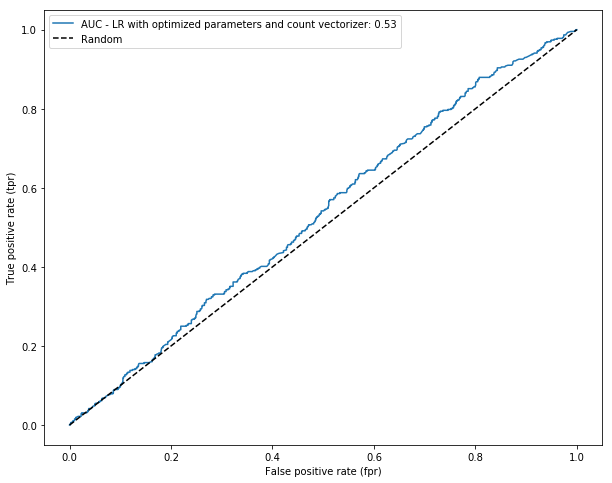

In [46]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

# Get the probability of Y_test records being = 1
Y_test_probability_1 = lr_cv2.predict_proba(X_test2)[:, 1]

#Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
tpr, fpr, thresholds = metrics.roc_curve(Y_test2, Y_test_probability_1)

# Plot the ROC curve
plt.plot(tpr, fpr, label="AUC - LR with optimized parameters and count vectorizer: " + str(round(auc, 2)))
    
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc=2)

### Random Forest

In [36]:

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train2, Y_train2)

print ("Area under the ROC curve on test data = %.3f" % metrics.roc_auc_score(rf.predict(X_test2), Y_test2))

Area under the ROC curve on test data = 0.471


From the grid search tests above, we see that neither Linear Regression not Random Forests seem to yield results that are siginificantly better than random.

Other methods including Gradient Descent and a Restricted Boltazman Machine Neural Net are implemented below. Because the count vectorizer performed better than the TFIDF vectorizer, we use this vectorization in these methods.

### Restricted Boltzmann Machine

In [ ]:
# from sklearn.neural_network import BernoulliRBM

# X1 = scipy.sparse.hstack((bigram_vectorizer.fit_transform(df_test.review_text), X_ntext))
# Y1 = df_test['count_crucial_signficant']
# X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, train_size=.75)

# model = BernoulliRBM()
# model.learning_rate = 0.06
# model.n_iter = 20
# # More components tend to give better prediction performance, but larger
# # fitting time
# model.n_components = 100

# model.fit(X_train1, Y_train1)
# print ("Area under the ROC curve on test data = %.3f" % metrics.roc_auc_score(model.predict(X_test1), Y_test1))